## Predicting Churn with Neural Networks

In this notebook, I attempt to build a model based on <code>Keras</code> library and train it on the same fictional telecoms company data used in other parts of this project. The code below is mainly adapted from <code>TensorFlow</code>'s [tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) on how to handle imbalanced data.

I will first train a model without taking the different class weights into account. I will then compare the results to another model that is trained with the class imbalance accounted for.

In [1]:
#loading the necessary python libraries
import pandas as pd
import numpy as np
import os
import tempfile

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#loading various libraries needed for preprocessing, modelling and evaluating
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
#loading the dataset into a pandas dataframe
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#applying the same naming convention to all column names
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
#creating a LabelEncoder object
le = LabelEncoder()

#enoding the target variable into numerical binary
customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
#creating a function to convert numerical binary data into categorical binary data
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

#applying the above function to the SeniorCitizen column
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
#creating a function to shorten the vocabulary for easier visualisation
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
#applying the above function to the PaymentMethod column
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
#removing all the customers who have been with the company for less than a month and deleting the CustomerID column
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

#converting TotalCharges from object to float data type
customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
#taking another look at the imbalance present in the data
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
##separating the target variable
target = customer_data.pop('Churn')

#dummifying the categorical features and removing any redundencies
customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

#adding the target variable back to the dummyfied data
customer_data_dum['Churn'] = target

In [11]:
#splitting the data into different train, test and validation sets
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
#creating numpy arrays from the available labels and features
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [13]:
#creating a StandardScaler object and standardising train, validation and test sets
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

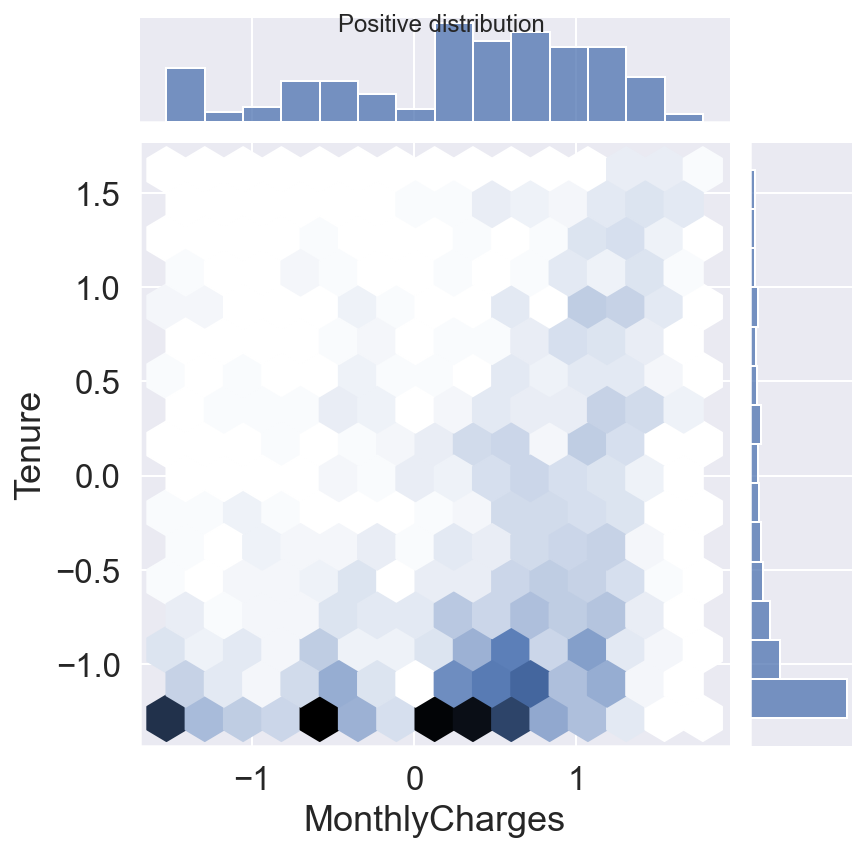

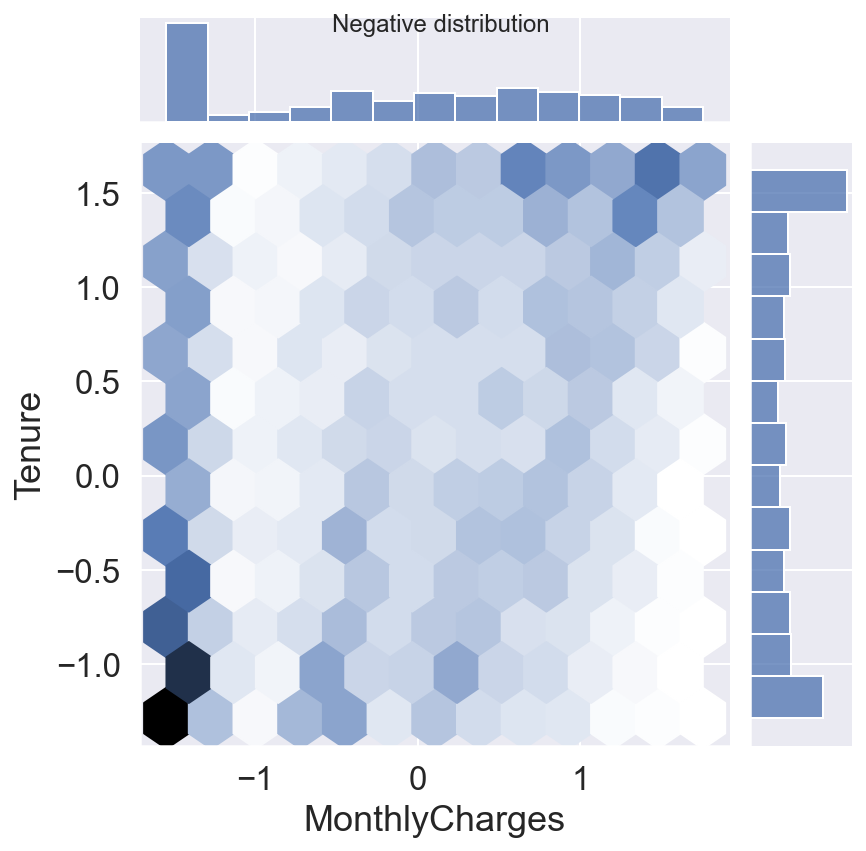

In [14]:
#separating the positive and negative churn instances into different dataframes
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

#surveying two sample distributions 
sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

#### Creating the Model and Defining the Metrics

In [15]:
#outlining the different metrics to use for model evaluation
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

#creating a function that creates a simple neural network with two densly connected hidden layers, two dropout layer
#for regularization, and one output layer to return the probability of churn
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu'),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [16]:
#defining the number of epochs and the batch size used during modelling
EPOCHS = 100
BATCH_SIZE = 256

#defining the early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

#building the model and printing out the summary
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


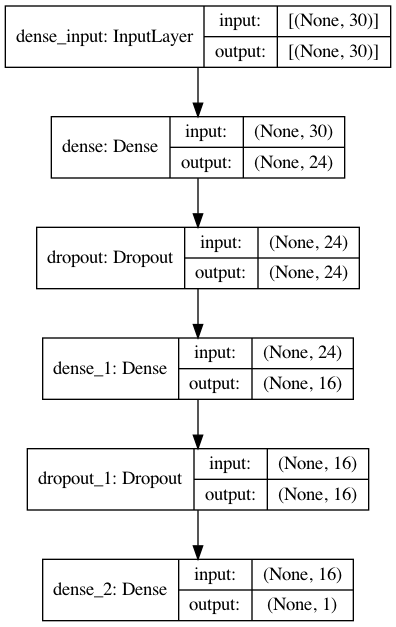

In [17]:
#plotting the model chart
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

#### Correcting the Initial Bias

Given the imbalanced nature of the data, we know that the automatically generated initial bias might not be great. Here, I will first check the machine generated biases and the ncompare the Loss to a another model that reflects this imbalance in its output layer.

In [18]:
#making predictions for the first 10 observations to test the model
model.predict(train_features[:10])

array([[0.7525741 ],
       [0.6230608 ],
       [0.47603434],
       [0.5084156 ],
       [0.7742435 ],
       [0.7163327 ],
       [0.7426317 ],
       [0.5289894 ],
       [0.79436874],
       [0.78477025]], dtype=float32)

In [19]:
#evaluating the Loss for these few predictions
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.9712


In [20]:
#calculating the initial bias based on the present imbalance
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [21]:
#inserting the new bias figure into the model and making predictions
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.18374959],
       [0.3003412 ],
       [0.13524553],
       [0.10011607],
       [0.24801242],
       [0.27194875],
       [0.19842747],
       [0.15055838],
       [0.2729986 ],
       [0.22183448]], dtype=float32)

In [22]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.5716


In [23]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [24]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [25]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [26]:
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

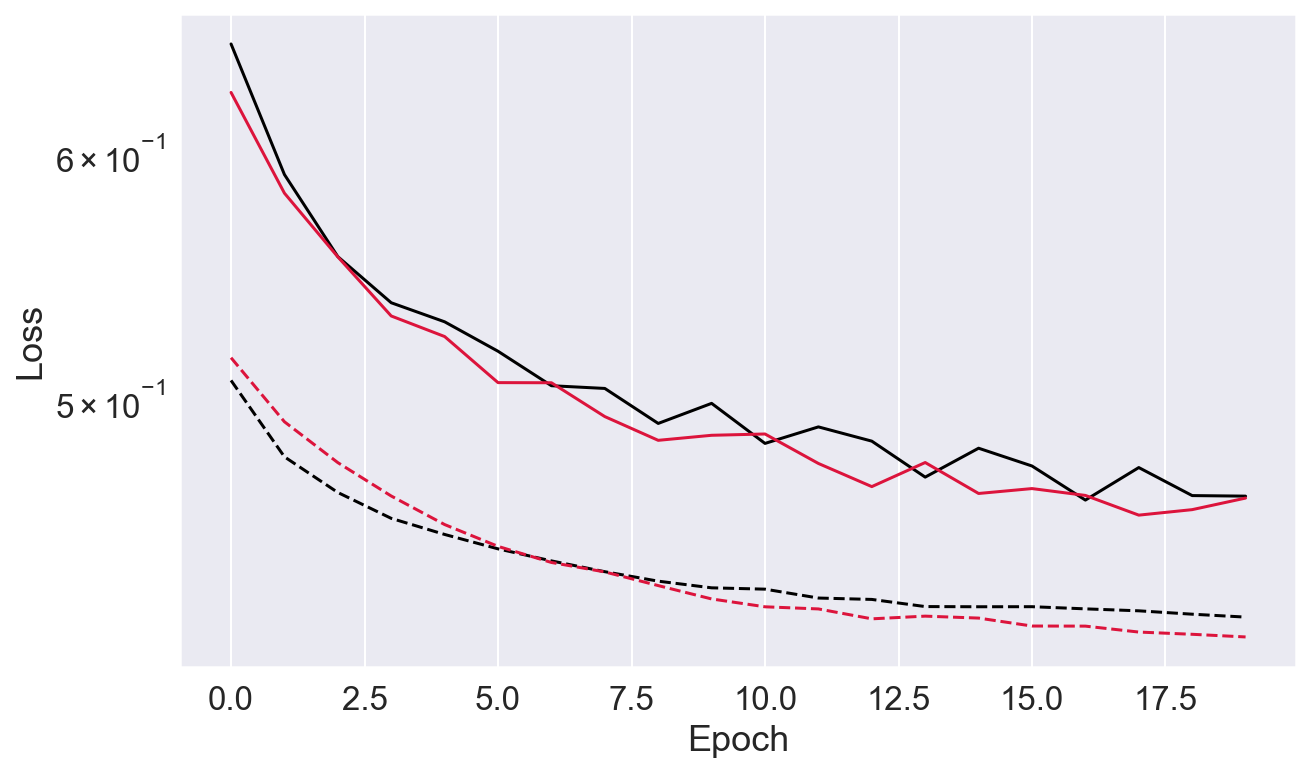

In [27]:
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

In [28]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
18/18 [==============================] - 2s 41ms/step - loss: 0.6272 - tp: 198.0000 - fp: 275.0000 - tn: 3855.0000 - fn: 1297.0000 - accuracy: 0.7205 - precision: 0.4186 - recall: 0.1324 - auc: 0.6456 - prc: 0.3595 - val_loss: 0.5164 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 299.0000 - val_accuracy: 0.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7458 - val_prc: 0.4432
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5746 - tp: 140.0000 - fp: 196.0000 - tn: 3108.0000 - fn: 1056.0000 - accuracy: 0.7218 - precision: 0.4167 - recall: 0.1171 - auc: 0.6555 - prc: 0.3627 - val_loss: 0.4898 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 298.0000 - val_accuracy: 0.7351 - val_precision: 1.0000 - val_recall: 0.0033 - val_auc: 0.7896 - val_prc: 0.5542
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5533 - tp: 163.0000 - fp: 215.0000 - tn: 3089.0000 - fn: 1033.

18/18 [==============================] - 0s 3ms/step - loss: 0.4603 - tp: 411.0000 - fp: 233.0000 - tn: 3071.0000 - fn: 785.0000 - accuracy: 0.7738 - precision: 0.6382 - recall: 0.3436 - auc: 0.8103 - prc: 0.5788 - val_loss: 0.4198 - val_tp: 125.0000 - val_fp: 52.0000 - val_tn: 774.0000 - val_fn: 174.0000 - val_accuracy: 0.7991 - val_precision: 0.7062 - val_recall: 0.4181 - val_auc: 0.8508 - val_prc: 0.6728
Epoch 21/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4593 - tp: 439.0000 - fp: 234.0000 - tn: 3070.0000 - fn: 757.0000 - accuracy: 0.7798 - precision: 0.6523 - recall: 0.3671 - auc: 0.8102 - prc: 0.5886 - val_loss: 0.4181 - val_tp: 133.0000 - val_fp: 59.0000 - val_tn: 767.0000 - val_fn: 166.0000 - val_accuracy: 0.8000 - val_precision: 0.6927 - val_recall: 0.4448 - val_auc: 0.8515 - val_prc: 0.6749
Epoch 22/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4607 - tp: 452.0000 - fp: 262.0000 - tn: 3042.0000 - fn: 744.0000 - accuracy: 0.7764 - pr

18/18 [==============================] - 0s 3ms/step - loss: 0.4427 - tp: 499.0000 - fp: 264.0000 - tn: 3040.0000 - fn: 697.0000 - accuracy: 0.7864 - precision: 0.6540 - recall: 0.4172 - auc: 0.8278 - prc: 0.6041 - val_loss: 0.4145 - val_tp: 133.0000 - val_fp: 55.0000 - val_tn: 771.0000 - val_fn: 166.0000 - val_accuracy: 0.8036 - val_precision: 0.7074 - val_recall: 0.4448 - val_auc: 0.8545 - val_prc: 0.6817
Epoch 40/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4404 - tp: 481.0000 - fp: 213.0000 - tn: 3091.0000 - fn: 715.0000 - accuracy: 0.7938 - precision: 0.6931 - recall: 0.4022 - auc: 0.8270 - prc: 0.6146 - val_loss: 0.4145 - val_tp: 134.0000 - val_fp: 55.0000 - val_tn: 771.0000 - val_fn: 165.0000 - val_accuracy: 0.8044 - val_precision: 0.7090 - val_recall: 0.4482 - val_auc: 0.8543 - val_prc: 0.6810
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4385 - tp: 484.0000 - fp: 260.0000 - tn: 3044.0000 - fn: 712.0000 - accuracy: 0.7840 - pr

In [29]:
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

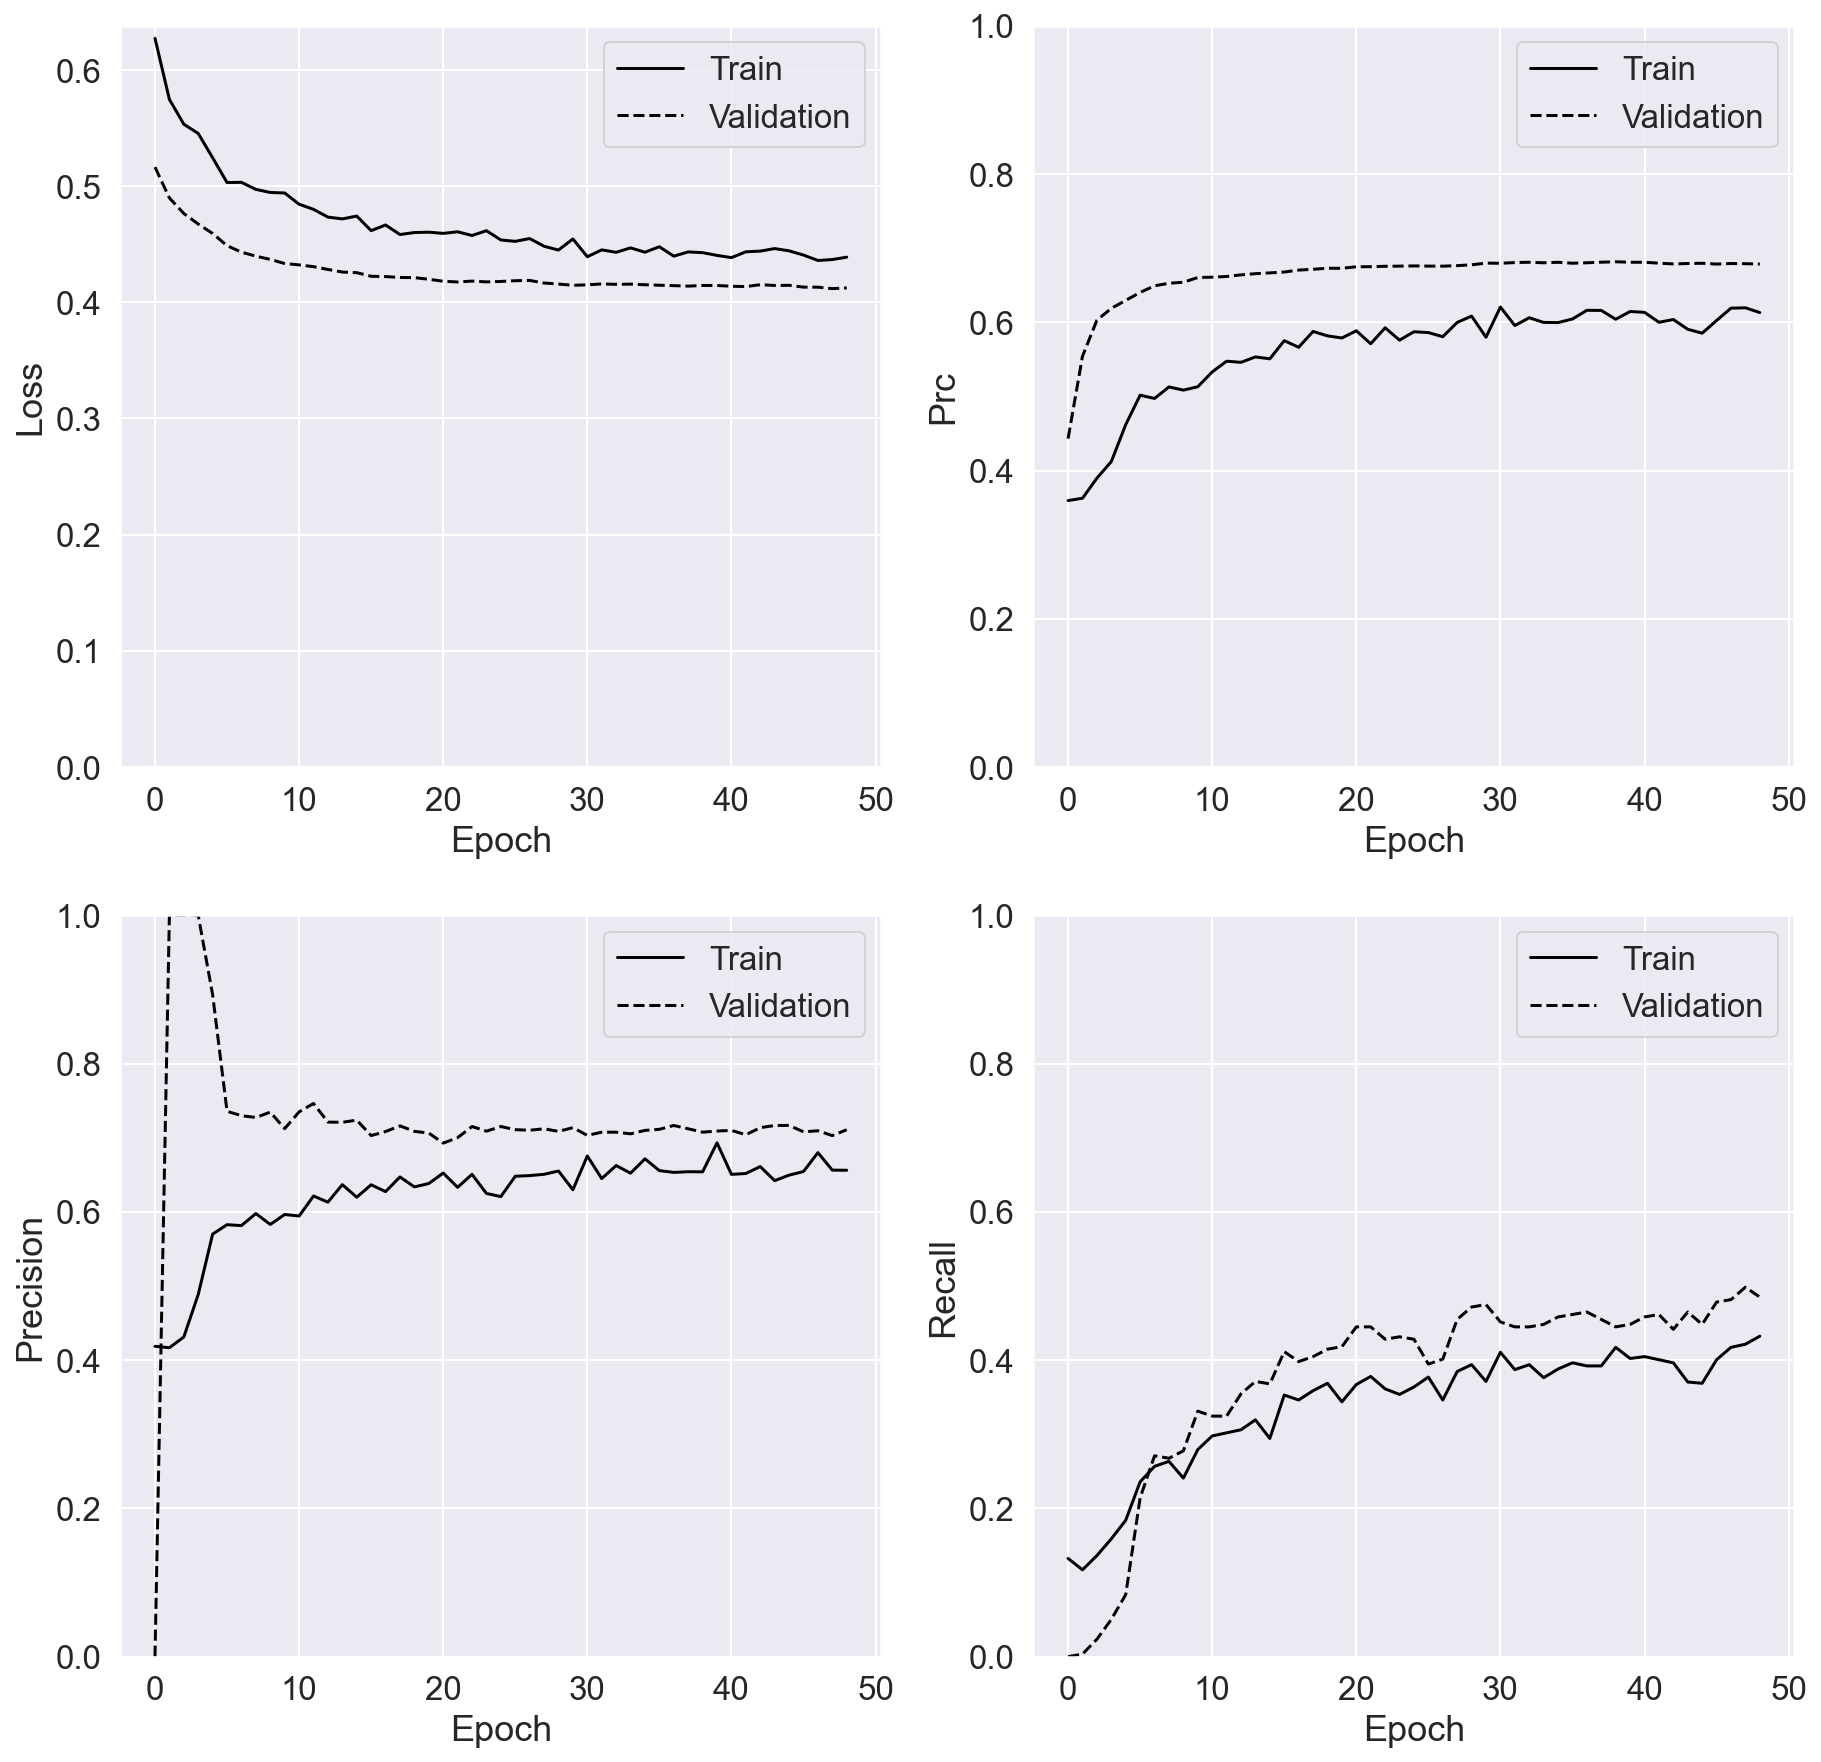

In [30]:
PlotMetrics(baseline_history)

In [31]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [32]:
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.42806276679039
tp :  164.0
fp :  85.0
tn :  948.0
fn :  210.0
accuracy :  0.7903340458869934
precision :  0.6586345434188843
recall :  0.4385026693344116
auc :  0.8369786143302917
prc :  0.6302945017814636


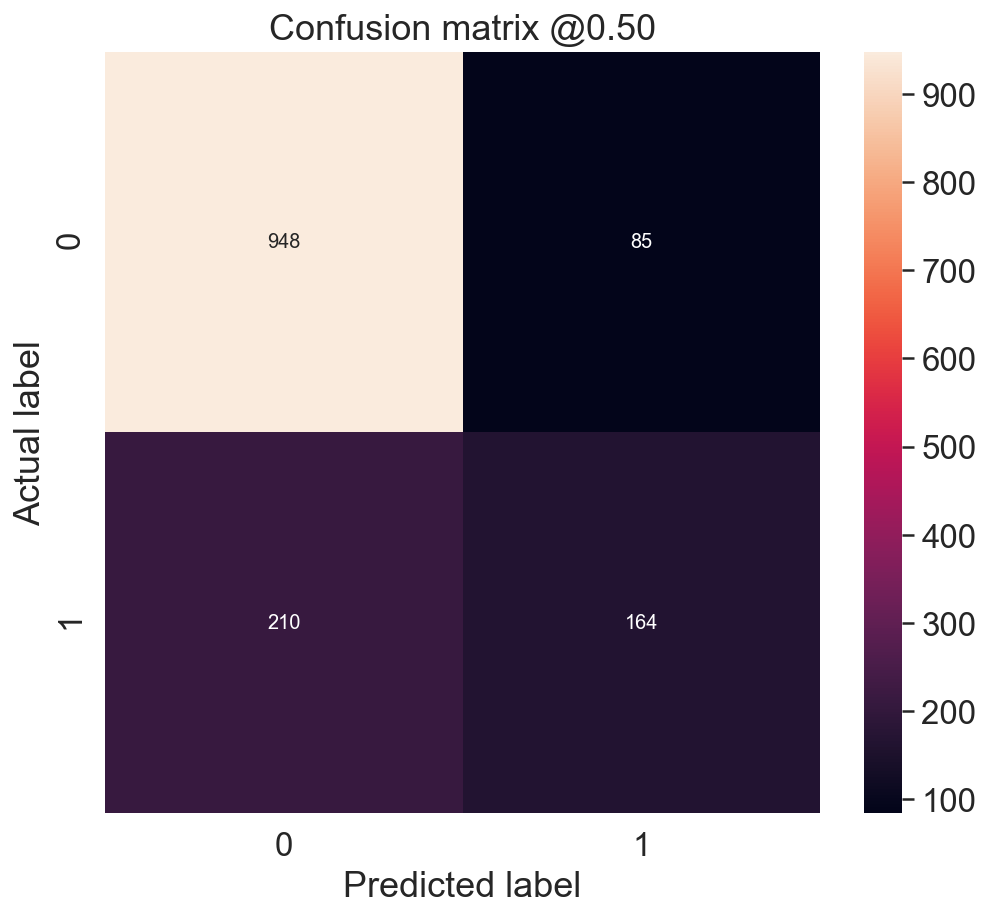

In [33]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [34]:
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

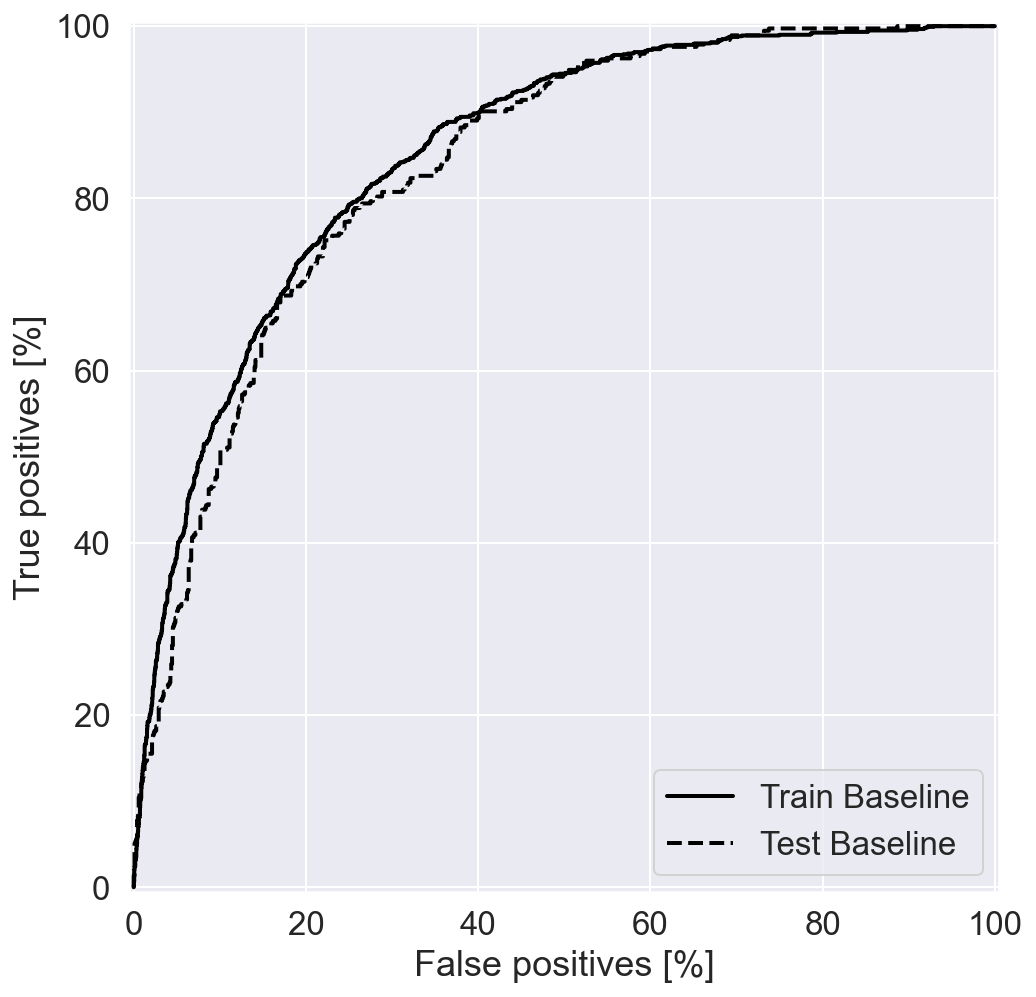

In [35]:
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [36]:
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

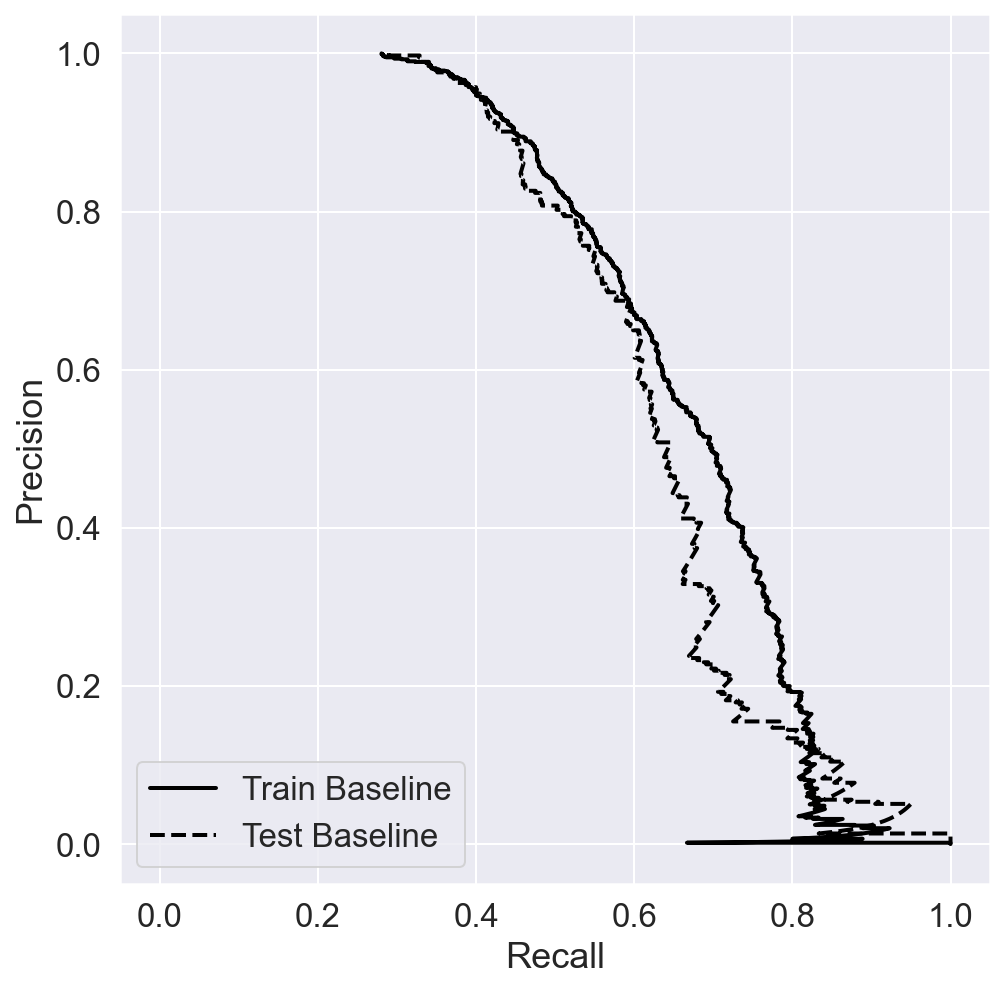

In [37]:
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

In [38]:
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [39]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
18/18 [==============================] - 2s 41ms/step - loss: 0.8991 - tp: 305.0000 - fp: 415.0000 - tn: 3922.0000 - fn: 1265.0000 - accuracy: 0.7156 - precision: 0.4236 - recall: 0.1943 - auc: 0.6480 - prc: 0.3602 - val_loss: 0.5306 - val_tp: 16.0000 - val_fp: 35.0000 - val_tn: 791.0000 - val_fn: 283.0000 - val_accuracy: 0.7173 - val_precision: 0.3137 - val_recall: 0.0535 - val_auc: 0.7020 - val_prc: 0.3783
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7671 - tp: 331.0000 - fp: 618.0000 - tn: 2686.0000 - fn: 865.0000 - accuracy: 0.6704 - precision: 0.3488 - recall: 0.2768 - auc: 0.6286 - prc: 0.3325 - val_loss: 0.5286 - val_tp: 114.0000 - val_fp: 120.0000 - val_tn: 706.0000 - val_fn: 185.0000 - val_accuracy: 0.7289 - val_precision: 0.4872 - val_recall: 0.3813 - val_auc: 0.7487 - val_prc: 0.4558
Epoch 3/100
18

18/18 [==============================] - 0s 3ms/step - loss: 0.5513 - tp: 771.0000 - fp: 696.0000 - tn: 2608.0000 - fn: 425.0000 - accuracy: 0.7509 - precision: 0.5256 - recall: 0.6446 - auc: 0.8029 - prc: 0.5692 - val_loss: 0.4790 - val_tp: 225.0000 - val_fp: 173.0000 - val_tn: 653.0000 - val_fn: 74.0000 - val_accuracy: 0.7804 - val_precision: 0.5653 - val_recall: 0.7525 - val_auc: 0.8506 - val_prc: 0.6760
Epoch 20/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5502 - tp: 777.0000 - fp: 694.0000 - tn: 2610.0000 - fn: 419.0000 - accuracy: 0.7527 - precision: 0.5282 - recall: 0.6497 - auc: 0.8034 - prc: 0.5735 - val_loss: 0.4747 - val_tp: 223.0000 - val_fp: 172.0000 - val_tn: 654.0000 - val_fn: 76.0000 - val_accuracy: 0.7796 - val_precision: 0.5646 - val_recall: 0.7458 - val_auc: 0.8511 - val_prc: 0.6757
Epoch 21/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5482 - tp: 776.0000 - fp: 722.0000 - tn: 2582.0000 - fn: 420.0000 - accuracy: 0.7462 - pr

18/18 [==============================] - 0s 3ms/step - loss: 0.5263 - tp: 824.0000 - fp: 690.0000 - tn: 2614.0000 - fn: 372.0000 - accuracy: 0.7640 - precision: 0.5443 - recall: 0.6890 - auc: 0.8205 - prc: 0.5900 - val_loss: 0.4681 - val_tp: 229.0000 - val_fp: 180.0000 - val_tn: 646.0000 - val_fn: 70.0000 - val_accuracy: 0.7778 - val_precision: 0.5599 - val_recall: 0.7659 - val_auc: 0.8535 - val_prc: 0.6838
Epoch 39/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5389 - tp: 816.0000 - fp: 729.0000 - tn: 2575.0000 - fn: 380.0000 - accuracy: 0.7536 - precision: 0.5282 - recall: 0.6823 - auc: 0.8153 - prc: 0.5816 - val_loss: 0.4684 - val_tp: 231.0000 - val_fp: 180.0000 - val_tn: 646.0000 - val_fn: 68.0000 - val_accuracy: 0.7796 - val_precision: 0.5620 - val_recall: 0.7726 - val_auc: 0.8526 - val_prc: 0.6840
Epoch 40/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5317 - tp: 818.0000 - fp: 705.0000 - tn: 2599.0000 - fn: 378.0000 - accuracy: 0.7593 - pr

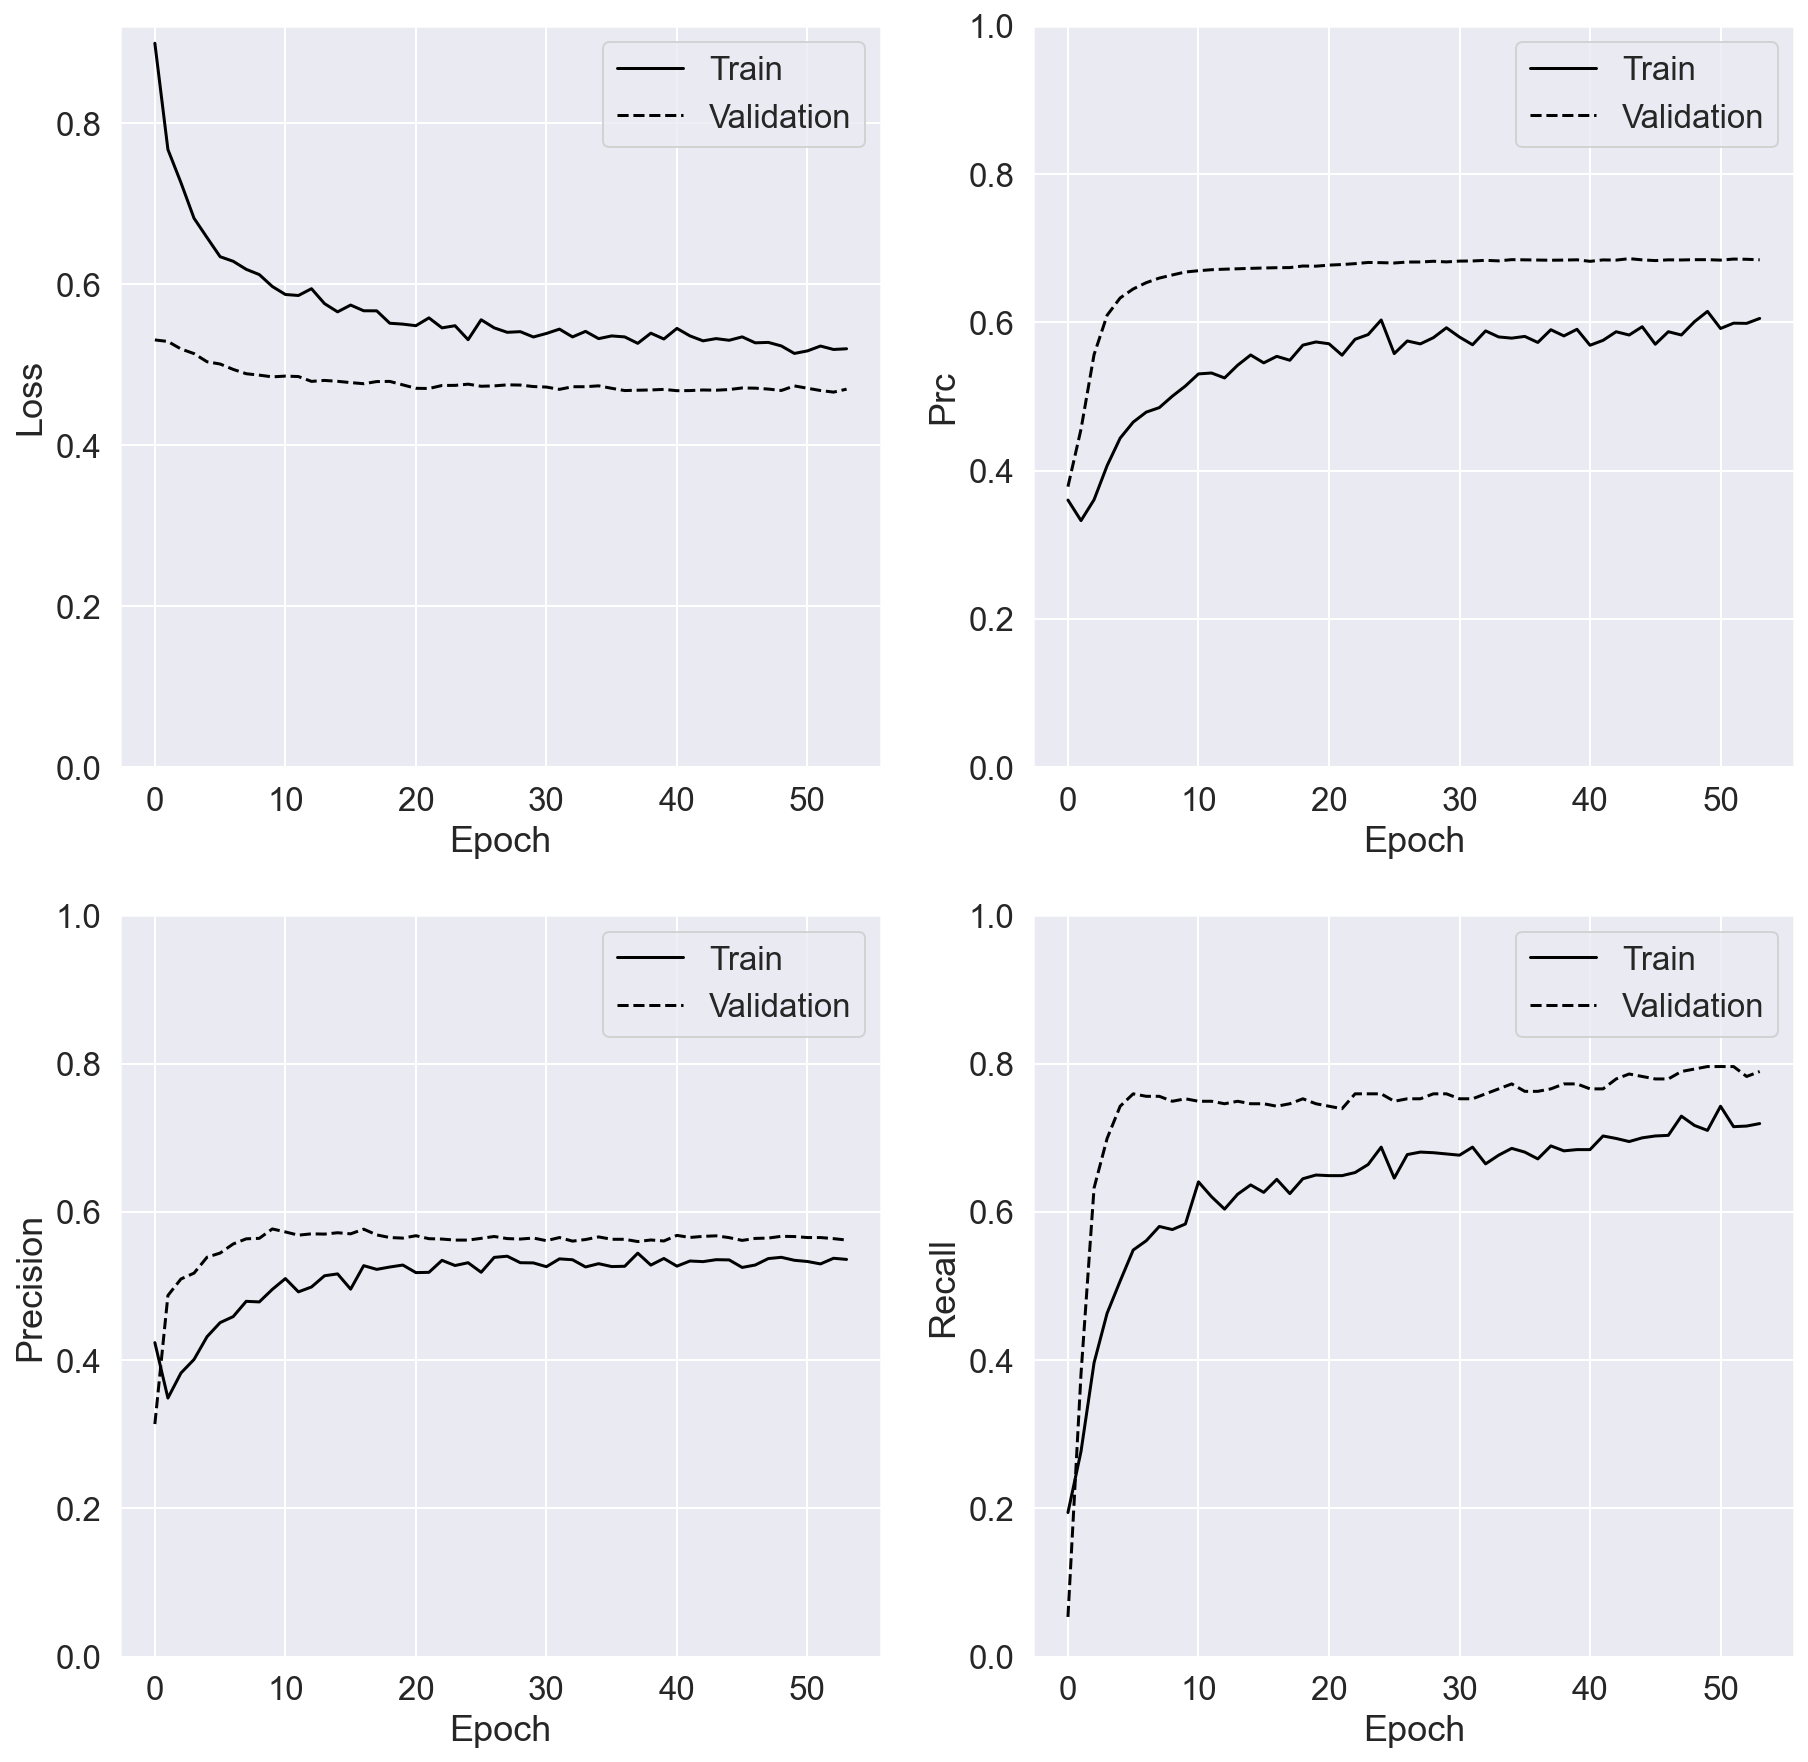

In [40]:
PlotMetrics(weighted_history)

In [41]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.49170711636543274
tp :  291.0
fp :  265.0
tn :  768.0
fn :  83.0
accuracy :  0.7526652216911316
precision :  0.5233812928199768
recall :  0.7780748605728149
auc :  0.8374251127243042
prc :  0.6346219778060913


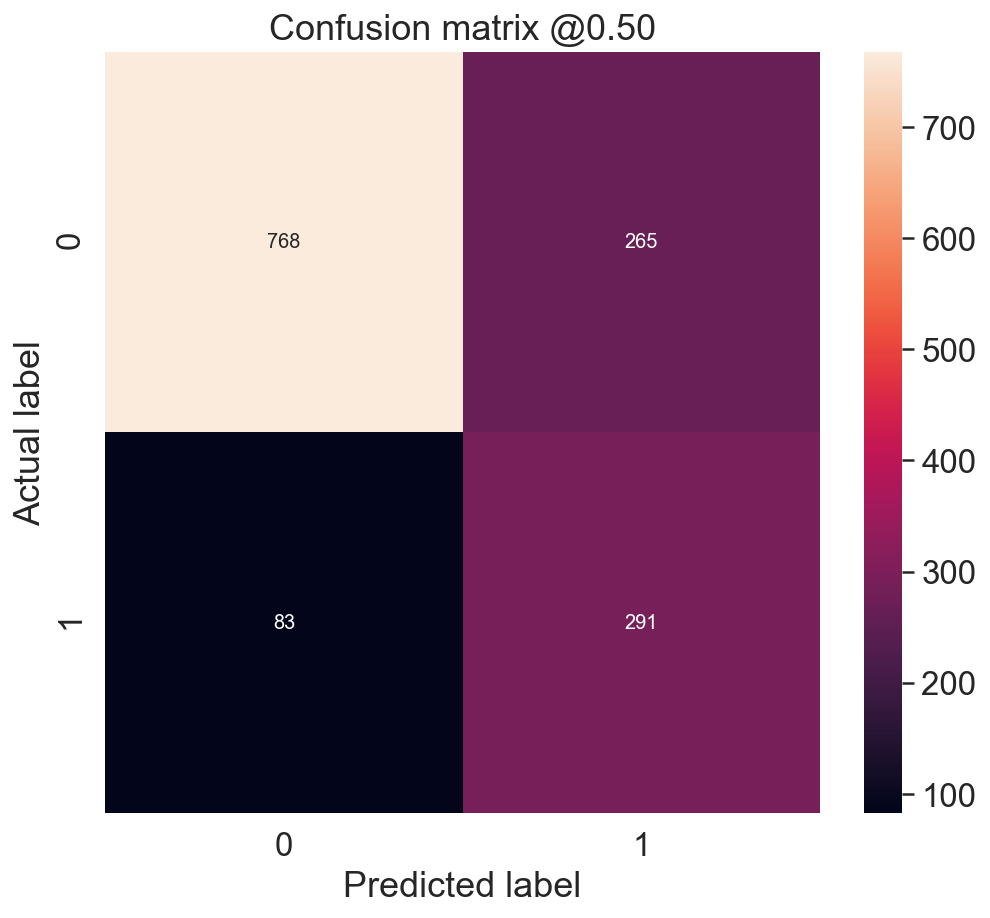

In [42]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

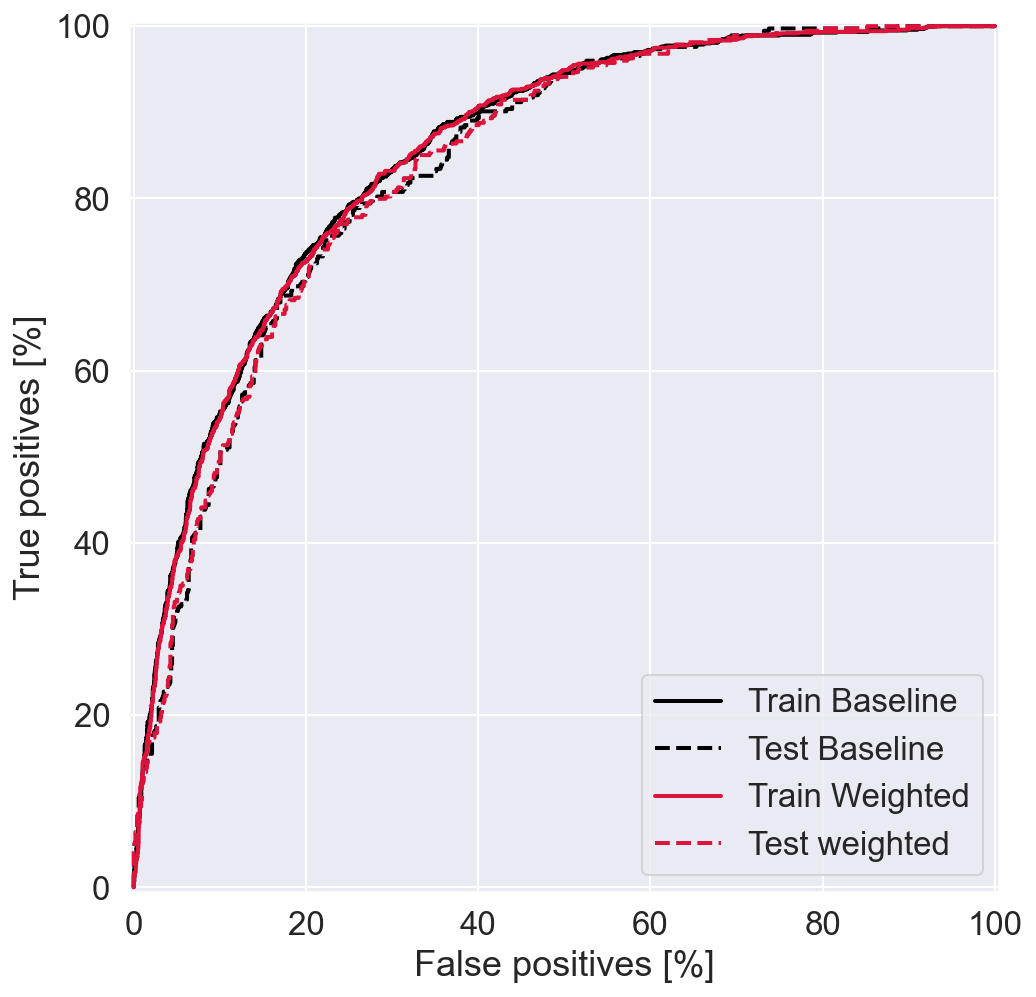

In [43]:
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

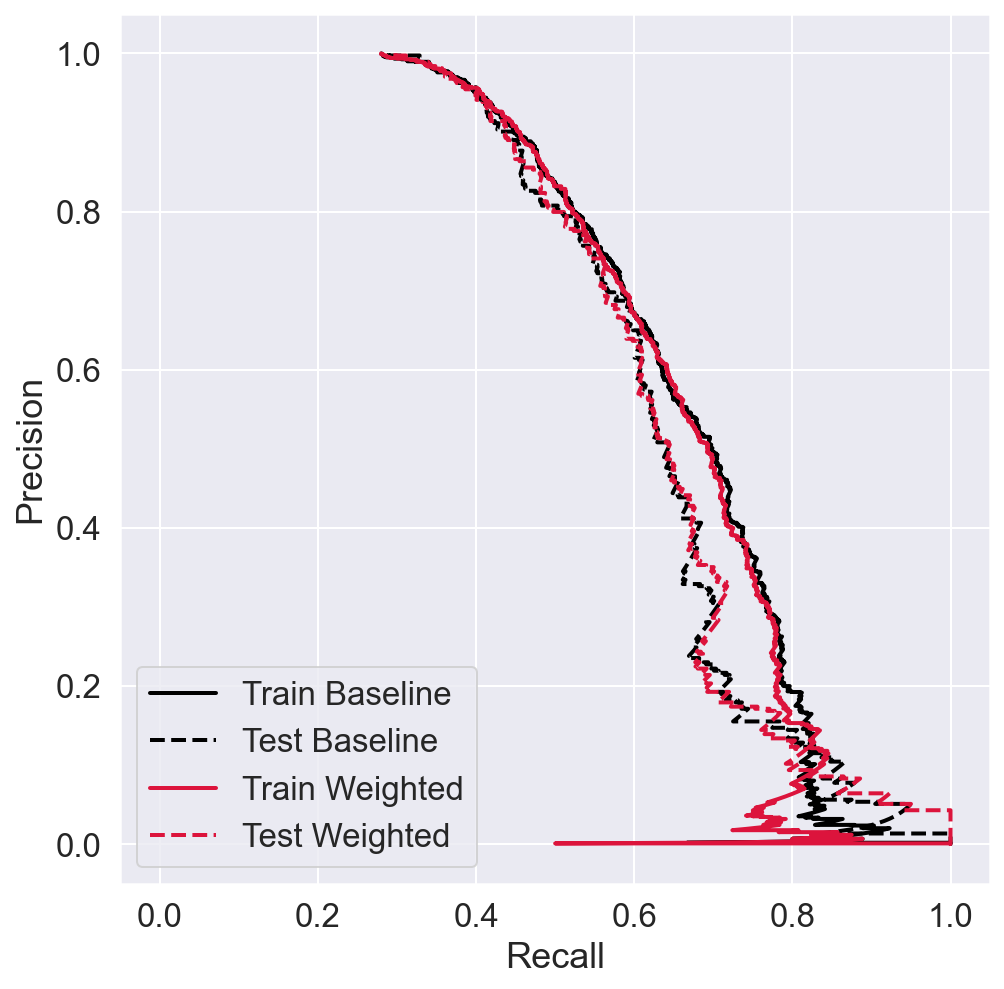

In [44]:
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')